['/home/dd6849/.conda/envs/diffuserClean/lib/python310.zip', '/home/dd6849/.conda/envs/diffuserClean/lib/python3.10', '/home/dd6849/.conda/envs/diffuserClean/lib/python3.10/lib-dynload', '', '/home/dd6849/.conda/envs/diffuserClean/lib/python3.10/site-packages', '/scratch/network/dd6849/rpmml-project/rpmml-project/src']


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from rpmml_project.pointmaze.point_maze import (MinariTrajectoryDataset, MinariTrajectoryDatasetWithActions, MinariTrajectoryDatasetWithPseudoActions, expand_spline_from_skip_list, estimate_dt_from_obs)

In [163]:
dataset = MinariTrajectoryDataset(
    dataset_name="D4RL/pointmaze/umaze-v2",
    horizon=32
)

In [164]:
env = dataset.dataset.recover_environment()

def unwrap_env(env):
    while hasattr(env, "env"):
        env = env.env
    return env

env = unwrap_env(env)     # <-- now env.model and env.sim work

mj_model = env.model          # or env.sim.model
mj_data = env.data

In [165]:
from matplotlib.patches import Rectangle
import mujoco

-2.0 2.0
-1.0 2.0
0.0 2.0
1.0 2.0
2.0 2.0
-2.0 1.0
2.0 1.0
-2.0 0.0
-1.0 0.0
0.0 0.0
2.0 0.0
-2.0 -1.0
2.0 -1.0
-2.0 -2.0
-1.0 -2.0
0.0 -2.0
1.0 -2.0
2.0 -2.0


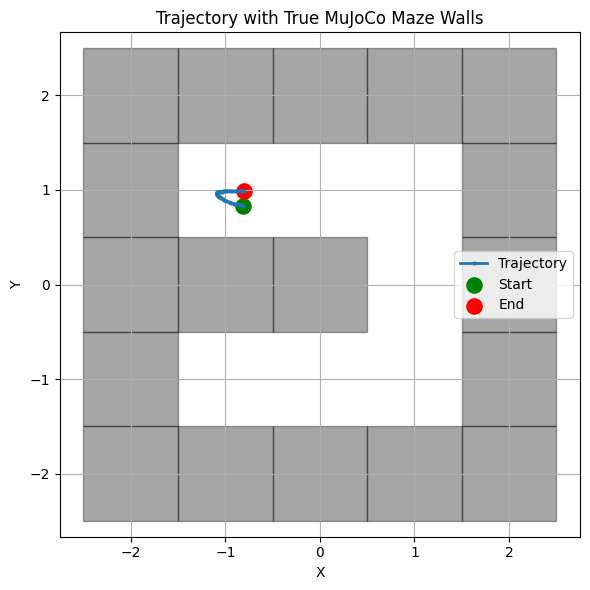

In [166]:
# -----------------------------
# Sample a trajectory window
# -----------------------------
idx = random.randint(0, len(dataset) - 1)
traj_norm = dataset[idx]
traj = dataset.denormalize(traj_norm).numpy()
xy = traj[:, :2]           # XY coordinates

# -----------------------------
# Plot the trajectory
# -----------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(xy[:, 0], xy[:, 1], marker='o', linewidth=2, markersize=2, label='Trajectory')
ax.scatter(xy[0, 0], xy[0, 1], c='green', s=120, label='Start')
ax.scatter(xy[-1, 0], xy[-1, 1], c='red', s=120, label='End')

# -----------------------------
# Render actual MuJoCo walls
# -----------------------------
for geom_id in range(mj_model.ngeom):

    # Get geom name
    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_GEOM, geom_id)

    if name is None or not "block" in name:
        continue

    pos = mj_model.geom_pos[geom_id]     # center (x, y, z)
    size = mj_model.geom_size[geom_id]   # half-extents (hx, hy, hz)

    cx, cy = pos[:2]
    hx, hy = size[:2]
    print(cx, cy)

    rect = Rectangle(
        (cx - hx, cy - hy),
        2 * hx,
        2 * hy,
        color="black",
        alpha=0.35,
        zorder=0
    )
    ax.add_patch(rect)


# -----------------------------
# Final figure styling
# -----------------------------
ax.set_title("Trajectory with True MuJoCo Maze Walls")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)
ax.legend()
plt.tight_layout()

plt.show()

In [167]:
datasetWithAcceleration = MinariTrajectoryDatasetWithActions(
    dataset_name="D4RL/pointmaze/umaze-v2",
    horizon=32
)

In [168]:
batch = datasetWithAcceleration[np.random.randint(len(datasetWithAcceleration))]
obs = batch["obs"].numpy()          # (H,4) 
actions = batch["act"].numpy()           # (H,2) true accelerations

pos = obs[:, :2]                         # true positions
vel_true = obs[:, 2:4]                   # true velocities (vx, vy)


In [169]:
dt = (estimate_dt_from_obs(pos, vel_true))
print(dt)
mass = 0.04239 # derived via excel, will be constant for this env, so not writing a function

0.009983658


(31, 2)
(30, 2)
(31, 2)
(30, 2)

==================== METRICS ====================
Velocity MSE: 1.5011256e-05
Velocity MAE: 0.0029909615
Acceleration MSE: 0.39600354
Acceleration MAE: 0.49372232



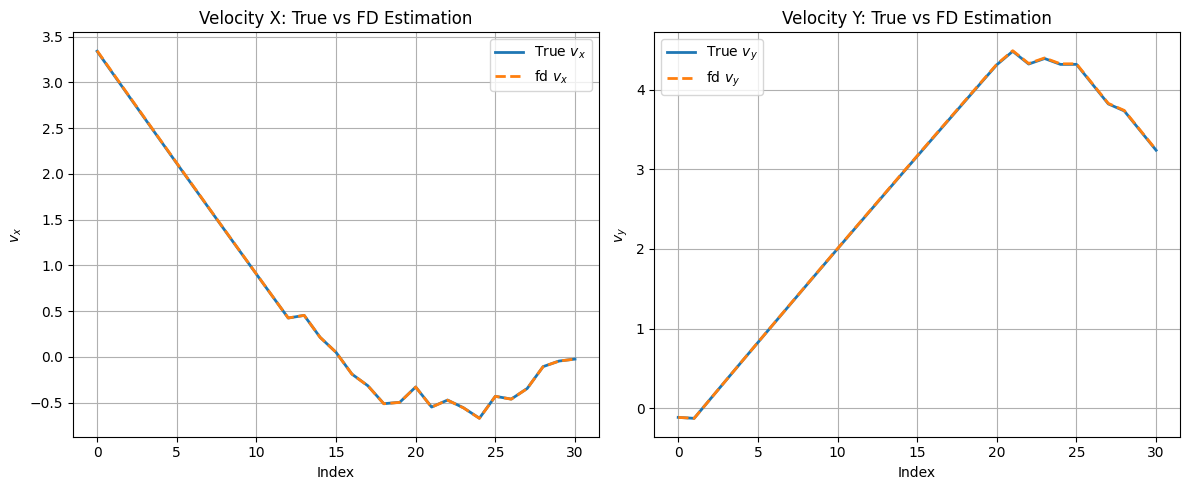

In [170]:

# Recover velocity and acceleration with our FD method
vel_fd, acc_fd = recover_actions_from_states(obs, dt, mass)
print(vel_fd.shape)
print(acc_fd.shape)
# Align true velocity with FD velocity (T-1)
vel_true_aligned = vel_true[1:]         # drop initial
print(vel_true_aligned.shape)
# Align accelerations
acc_true_aligned = actions[1:-1]/mass        # (T-2)
print(acc_true_aligned.shape)
# -----------------------------------------------------
# Compute metrics
# -----------------------------------------------------
vel_mse = np.mean((vel_fd - vel_true_aligned)**2)
vel_mae = np.mean(np.abs(vel_fd - vel_true_aligned))

acc_mse = np.mean((acc_fd - acc_true_aligned)**2)
acc_mae = np.mean(np.abs(acc_fd - acc_true_aligned))

print("\n==================== METRICS ====================")
print("Velocity MSE:", vel_mse)
print("Velocity MAE:", vel_mae)
print("Acceleration MSE:", acc_mse)
print("Acceleration MAE:", acc_mae)
print("=================================================\n")

plt.figure(figsize=(12,5))

# vx comparison
plt.subplot(1,2,1)
plt.plot(vel_true_aligned[:,0], label="True $v_x$", linewidth=2)
plt.plot(vel_fd[:,0], '--', label="fd $v_x$", linewidth=2)
plt.xlabel("Index")
plt.ylabel("$v_x$")
plt.title("Velocity X: True vs FD Estimation")
plt.grid(True)
plt.legend()

# vy comparison
plt.subplot(1,2,2)
plt.plot(vel_true_aligned[:,1], label="True $v_y$", linewidth=2)
plt.plot(vel_fd[:,1], '--', label="fd $v_y$", linewidth=2)
plt.xlabel("Index")
plt.ylabel("$v_y$")
plt.title("Velocity Y: True vs FD Estimation")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


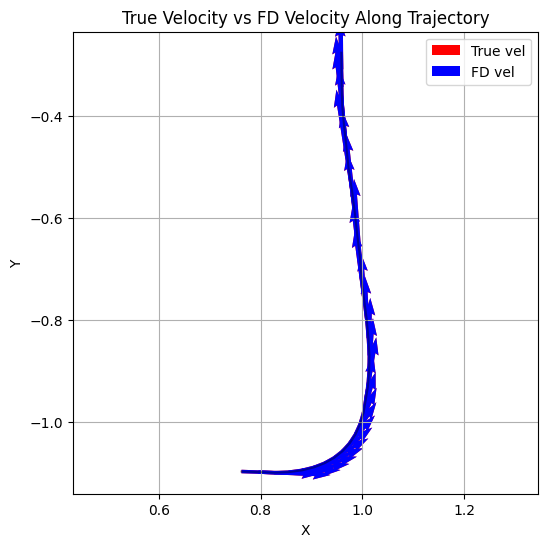

In [171]:
plt.figure(figsize=(6,6))
plt.plot(pos[:,0], pos[:,1], 'k-', alpha=0.4)

plt.quiver(
    pos[:-1,0], pos[:-1,1],
    vel_true_aligned[:,0], vel_true_aligned[:,1],
    color='r', scale=20, label="True vel"
)
plt.quiver(
    pos[:-1,0], pos[:-1,1],
    vel_fd[:,0], vel_fd[:,1],
    color='b', scale=20, label="FD vel"
)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("True Velocity vs FD Velocity Along Trajectory")
plt.axis("equal")
plt.grid()
plt.legend()
plt.show()


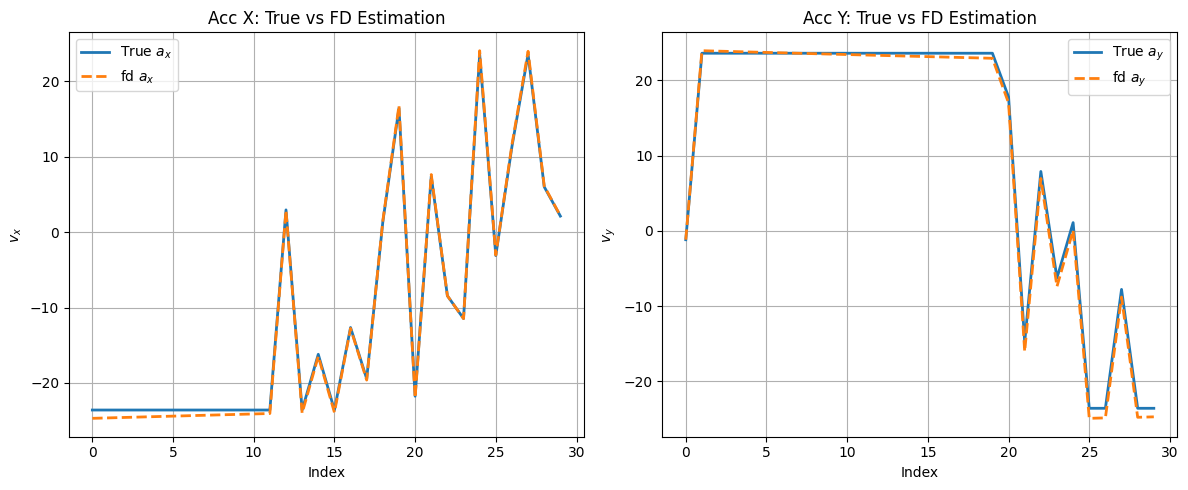

In [172]:
# there just is going to be a significant error here

plt.figure(figsize=(12,5))

# vx comparison
plt.subplot(1,2,1)
plt.plot(acc_true_aligned[:,0], label="True $a_x$", linewidth=2)
plt.plot(acc_fd[:,0], '--', label="fd $a_x$", linewidth=2)
plt.xlabel("Index")
plt.ylabel("$v_x$")
plt.title("Acc X: True vs FD Estimation")
plt.grid(True)
plt.legend()

# vy comparison
plt.subplot(1,2,2)
plt.plot(acc_true_aligned[:,1], label="True $a_y$", linewidth=2)
plt.plot(acc_fd[:,1], '--', label="fd $a_y$", linewidth=2)
plt.xlabel("Index")
plt.ylabel("$v_y$")
plt.title("Acc Y: True vs FD Estimation")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


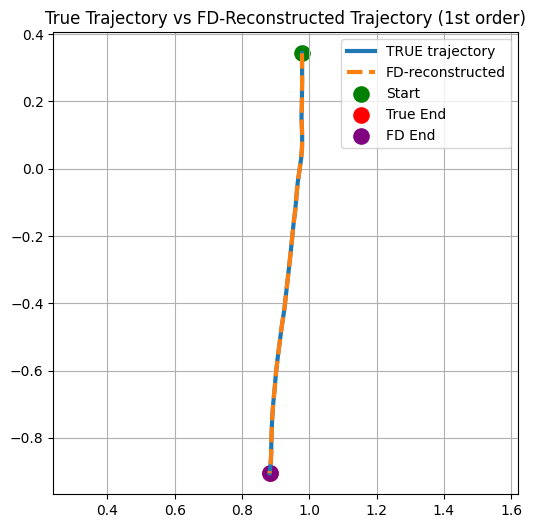

In [173]:
# this is pretty close
# ------------------------------------------------------------
# Sample one trajectory window (states + true accelerations)
# ------------------------------------------------------------
batch = datasetWithAcceleration[np.random.randint(len(datasetWithAcceleration))]

obs = batch["obs"].numpy()      # (H,4) 
act_true = batch["act"].numpy()      # (H,2) true accelerations

# Denormalize positions & velocities
pos = obs[:, :2]                     # (H,2)
vel_true = obs[:, 2:4]               # (H,2)
dt = estimate_dt_from_obs(pos, vel_true)
# Estimate velocities & accelerations via FD
vel_fd, acc_fd = recover_actions_from_states(obs, dt)

# ------------------------------------------------------------
# Simulate forward using FD dynamics, 1st order reconstruction
# ------------------------------------------------------------

H = len(obs)

x_fd_recon = np.zeros((H,2))


# Initial conditions match ground truth
x_fd_recon[0] = pos[0]

for t in range(H-1):
    # Update position
    x_fd_recon[t+1] = x_fd_recon[t] + vel_fd[t] * dt

# ------------------------------------------------------------
# Plot comparison
# ------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.plot(pos[:,0], pos[:,1], label="TRUE trajectory", linewidth=3)
plt.plot(x_fd_recon[:,0], x_fd_recon[:,1], label="FD-reconstructed", linestyle="--", linewidth=3)

plt.scatter(pos[0,0], pos[0,1], c="green", s=120, label="Start")
plt.scatter(pos[-1,0], pos[-1,1], c="red", s=120, label="True End")
plt.scatter(x_fd_recon[-1,0], x_fd_recon[-1,1], c="purple", s=120, label="FD End")

plt.legend()
plt.title("True Trajectory vs FD-Reconstructed Trajectory (1st order)")
plt.grid(True)
plt.axis("equal")
plt.show()


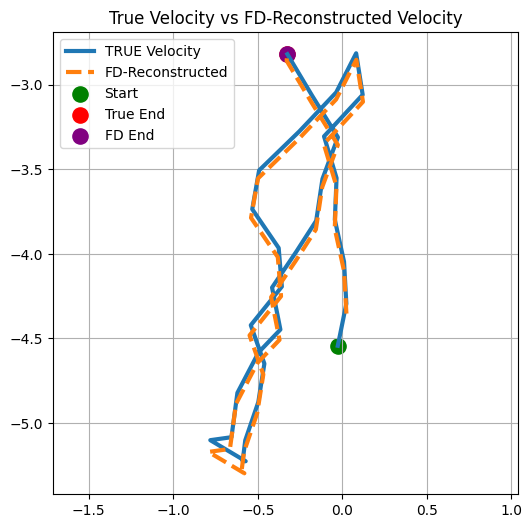

In [174]:
# Initialize reconstructed velocities
v_fd_recon = np.zeros((H, 2))

# Match ground-truth initial velocity
v_fd_recon[0] = vel_fd[0]

# Reconstruct velocities: a[t] corresponds to update from v[t] -> v[t+1]
for t in range(H - 2):
    v_fd_recon[t+1] = v_fd_recon[t] + acc_fd[t] * dt

# The final velocity (index H-1) cannot be reconstructed from acc_fd (size H-2)
# So copy true last velocity to align lengths
v_fd_recon[-1] = vel_true[-1]


# ------------------------------------------------------------
# Plot comparison
# ------------------------------------------------------------
plt.figure(figsize=(6,6))

plt.plot(
    vel_true[:,0], vel_true[:,1],
    label="TRUE Velocity", linewidth=3
)

plt.plot(
    v_fd_recon[:,0], v_fd_recon[:,1],
    '--', linewidth=3, label="FD-Reconstructed"
)

plt.scatter(vel_true[0,0], vel_true[0,1], c="green", s=120, label="Start")
plt.scatter(vel_true[-1,0], vel_true[-1,1], c="red", s=120, label="True End")
plt.scatter(v_fd_recon[-1,0], v_fd_recon[-1,1], c="purple", s=120, label="FD End")

plt.legend()
plt.title("True Velocity vs FD-Reconstructed Velocity")
plt.grid(True)
plt.axis("equal")
plt.show()

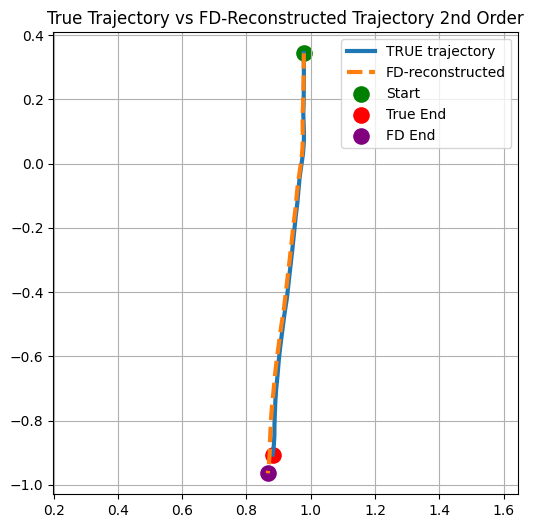

In [175]:
# This reconstruction is worse
# acc_fd has shape (H-2, 2)
# vel_true has shape (H,2)
# pos has shape (H,2)
# ----------------------------------------------
# 1. Reconstruct velocities
# ----------------------------------------------
vel_fd_recon = np.zeros((H, 2))

# match initial velocity
vel_fd_recon[0] = vel_true[0]

for t in range(H - 2):
    # v[t+1] = v[t] + a[t] * dt
    vel_fd_recon[t+1] = vel_fd_recon[t] + acc_fd[t] * dt

# last velocity cannot be reconstructed → copy true
vel_fd_recon[-1] = vel_true[-1]

# ----------------------------------------------
# 2. Reconstruct positions
# ----------------------------------------------
x_fd_recon = np.zeros((H, 2))
x_fd_recon[0] = pos[0]

for t in range(H - 1):
    # x[t+1] = x[t] + v[t] * dt
    x_fd_recon[t+1] = x_fd_recon[t] + vel_fd_recon[t] * dt

# ------------------------------------------------------------
# Plot comparison
# ------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.plot(pos[:,0], pos[:,1], label="TRUE trajectory", linewidth=3)
plt.plot(x_fd_recon[:,0], x_fd_recon[:,1], '--', linewidth=3, label="FD-reconstructed")

plt.scatter(pos[0,0], pos[0,1], c="green", s=120, label="Start")
plt.scatter(pos[-1,0], pos[-1,1], c="red", s=120, label="True End")
plt.scatter(x_fd_recon[-1,0], x_fd_recon[-1,1], c="purple", s=120, label="FD End")

plt.legend()
plt.title("True Trajectory vs FD-Reconstructed Trajectory 2nd Order")
plt.grid(True)
plt.axis("equal")
plt.show()

In [183]:
# From here on out, let's generate a sample list of tuples with state and timesteps skipped
# And use it for spine interpolation

def generate_skipped_waypoints(positions, max_skip=5):
    """
    Given a trajectory of 2D positions (T,2),
    produce a list of (state_xy, skip_amount).

    Args:
        positions: numpy array of shape (T,2)
        max_skip: maximum number of timesteps to skip forward

    Returns:
        waypoints: list of tuples (state_xy, skip_k)
    """
    T = len(positions)
    waypoints = []

    t = 0
    while t < T - 1:
        remaining = T - 1 - t
        skip = random.randint(1, min(max_skip, remaining))

        s = positions[t]
        waypoints.append( (s.copy(), skip) )

        t += skip

    return waypoints

In [184]:
pos = traj[:, :2]   
skip_list = generate_skipped_waypoints(pos) 
p_spline, v_spline, a_spline = expand_spline_from_skip_list(skip_list)



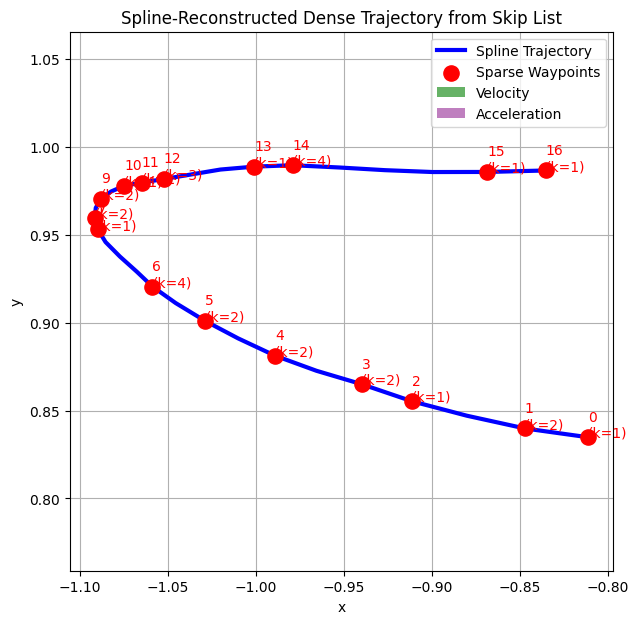

In [185]:


# ---------------------------------------
# Extract the sparse positions from skip_list
# ---------------------------------------
sparse_pos = np.array([p for p, k in skip_list])

# ---------------------------------------
# Start plotting
# ---------------------------------------
plt.figure(figsize=(7,7))

# ---- Plot spline trajectory (dense) ----
plt.plot(
    p_spline[:,0], p_spline[:,1],
    linewidth=3, color="blue", label="Spline Trajectory"
)

# ---- Plot sparse waypoints ----
plt.scatter(
    sparse_pos[:,0], sparse_pos[:,1],
    color="red", s=120, zorder=5,
    label="Sparse Waypoints"
)

# Label sparse waypoints
for i, (p, k) in enumerate(skip_list):
    plt.text(
        p[0], p[1],
        f"{i}\n(k={k})",
        fontsize=10, color="red"
    )

# ---------------------------------------
# Velocity vectors
# ---------------------------------------
plt.quiver(
    p_spline[:,0], p_spline[:,1],
    v_spline[:,0], v_spline[:,1],
    color="green", scale=20, width=0.004,
    alpha=0.6, label="Velocity"
)

# ---------------------------------------
# Acceleration vectors
# ---------------------------------------
plt.quiver(
    p_spline[:,0], p_spline[:,1],
    a_spline[:,0], a_spline[:,1],
    color="purple", scale=50, width=0.003,
    alpha=0.5, label="Acceleration"
)

# ---------------------------------------
# Styling
# ---------------------------------------
plt.title("Spline-Reconstructed Dense Trajectory from Skip List")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis("equal")
plt.legend()

plt.show()


In [186]:
print("===================================================")
print(" WAYPOINT COMPARISON: FD Predicted vs Sparse")
print("===================================================\n")

errors = []

current_idx = 0

for i, (sparse_pos, skip) in enumerate(skip_list[:-1]):   # second-last
    next_sparse_pos = skip_list[i+1][0]
    k = skip

    pred_pos = p_spline[current_idx].copy()
    pred_vel = vel_fd[current_idx].copy()

    for step in range(k):

        # prevent IndexError by clamping index
        acc_idx = min(current_idx + step, len(acc_fd) - 1)

        pred_vel = pred_vel + acc_fd[acc_idx] * dt
        pred_pos = pred_pos + pred_vel * dt

    true_pos = next_sparse_pos
    err = np.linalg.norm(pred_pos - true_pos)
    errors.append(err)

    print(f"Segment {i}: skip = {k}")
    print("  True waypoint:      ", true_pos)
    print("  Predicted waypoint: ", pred_pos)
    print("  Error (L2):          {:.6f}\n".format(err))

    current_idx += k

print("===================================================")
print("Mean Error:  ", np.mean(errors))
print("Max Error:   ", np.max(errors))
print("===================================================")


 WAYPOINT COMPARISON: FD Predicted vs Sparse

Segment 0: skip = 1
  True waypoint:       [-0.84717248  0.83981758]
  Predicted waypoint:  [-0.84615904  0.84202926]
  Error (L2):          0.002433

Segment 1: skip = 2
  True waypoint:       [-0.91134258  0.85525931]
  Predicted waypoint:  [-0.90705882  0.85536172]
  Error (L2):          0.004285

Segment 2: skip = 1
  True waypoint:       [-0.93974199  0.8648977 ]
  Predicted waypoint:  [-0.9364725   0.86347726]
  Error (L2):          0.003565

Segment 3: skip = 2
  True waypoint:       [-0.98919901  0.88117109]
  Predicted waypoint:  [-0.98513815  0.88229874]
  Error (L2):          0.004215

Segment 4: skip = 2
  True waypoint:       [-1.02890532  0.90088894]
  Predicted waypoint:  [-1.02377497  0.90180373]
  Error (L2):          0.005211

Segment 5: skip = 2
  True waypoint:       [-1.0589076   0.92047877]
  Predicted waypoint:  [-1.05434545  0.9187254 ]
  Error (L2):          0.004887

Segment 6: skip = 4
  True waypoint:       [-1.0

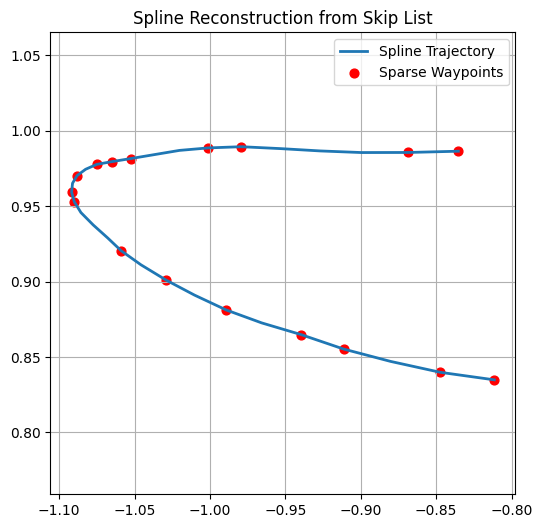

In [191]:
sparse_positions = np.array([p for (p, k) in skip_list])
plt.figure(figsize=(6,6))
plt.plot(p_spline[:,0], p_spline[:,1], label="Spline Trajectory", linewidth=2)
plt.scatter(sparse_positions[:,0], sparse_positions[:,1], color='red', s=40, label="Sparse Waypoints")
plt.axis('equal')
plt.legend()
plt.title("Spline Reconstruction from Skip List")
plt.grid()
plt.show()

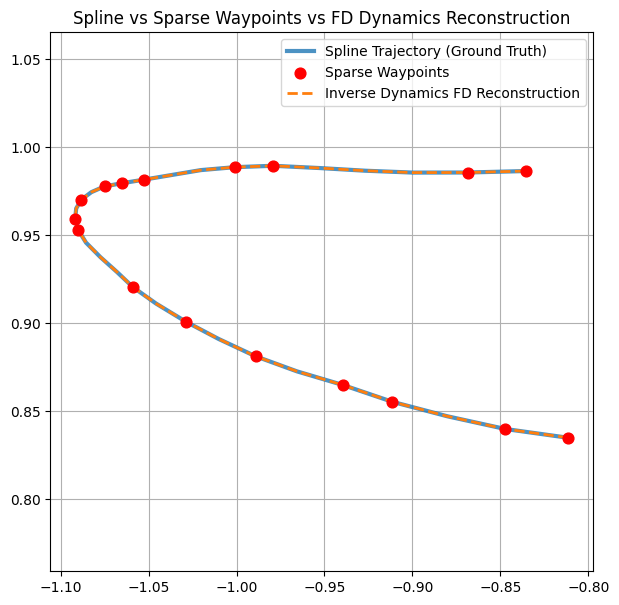

In [194]:
# ------------------------------------------------------------
# 1. Recover velocities and accelerations from spline
# ------------------------------------------------------------
vel_fd, acc_fd = recover_actions_from_states(p_spline, dt=dt)
# vel_fd shape: (N-1,2)
# acc_fd shape: (N-2,2)

N = len(p_spline)

# ------------------------------------------------------------
# 2. Reconstruct velocities using acc_fd
# ------------------------------------------------------------
vel_fd_recon = np.zeros((N, 2))
vel_fd_recon[0] = vel_fd[0]             # match initial velocity

for t in range(N - 2):
    vel_fd_recon[t+1] = vel_fd_recon[t] + acc_fd[t] * dt

# Last velocity cannot be reconstructed, so copy true
vel_fd_recon[-1] = vel_fd[-1]

# ------------------------------------------------------------
# 3. Reconstruct positions using vel_fd_recon
# ------------------------------------------------------------
x_fd_recon = np.zeros((N, 2))
x_fd_recon[0] = p_spline[0]             # initial pos matches spline

for t in range(N - 1):
    x_fd_recon[t+1] = x_fd_recon[t] + vel_fd_recon[t] * dt

# ------------------------------------------------------------
# 4. Visualization
# ------------------------------------------------------------
plt.figure(figsize=(7,7))

# Spline trajectory (ground truth from spline expansion)
plt.plot(
    p_spline[:,0], p_spline[:,1],
    label="Spline Trajectory (Ground Truth)", linewidth=3, alpha=0.8
)

# Sparse waypoints (checkpoints)
sparse_positions = np.array([p for (p,k) in skip_list])
plt.scatter(
    sparse_positions[:,0], sparse_positions[:,1],
    color='red', s=60, label="Sparse Waypoints", zorder=5
)

# Reconstruction from FD dynamics
plt.plot(
    x_fd_recon[:,0], x_fd_recon[:,1],
    '--', linewidth=2, label="Inverse Dynamics FD Reconstruction"
)

plt.axis('equal')
plt.title("Spline vs Sparse Waypoints vs FD Dynamics Reconstruction")
plt.legend()
plt.grid()
plt.show()


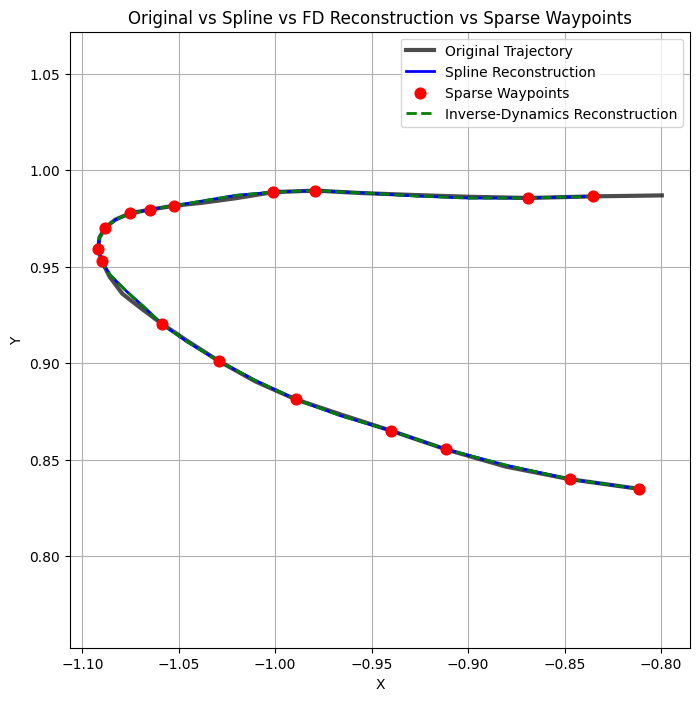

In [195]:
plt.figure(figsize=(8,8))

# -----------------------------------------------------------
# 1. Original (true) trajectory from dataset
# -----------------------------------------------------------
plt.plot(
    pos[:,0], pos[:,1],
    label="Original Trajectory",
    color="black",
    linewidth=3,
    alpha=0.7,
)

# -----------------------------------------------------------
# 2. Spline (dense reconstruction from skip list)
# -----------------------------------------------------------
plt.plot(
    p_spline[:,0], p_spline[:,1],
    label="Spline Reconstruction",
    linewidth=2,
    color="blue",
)

# -----------------------------------------------------------
# 3. Sparse waypoints (skip-interval representation)
# -----------------------------------------------------------
sparse_positions = np.array([p for (p,k) in skip_list])
plt.scatter(
    sparse_positions[:,0], sparse_positions[:,1],
    color='red', s=60, label="Sparse Waypoints", zorder=5
)

# -----------------------------------------------------------
# 4. Trajectory reconstructed from FD inverse dynamics
# -----------------------------------------------------------
plt.plot(
    x_fd_recon[:,0], x_fd_recon[:,1],
    "--", linewidth=2, label="Inverse-Dynamics Reconstruction",
    color="green"
)

# -----------------------------------------------------------
# Final styling
# -----------------------------------------------------------
plt.axis('equal')
plt.title("Original vs Spline vs FD Reconstruction vs Sparse Waypoints")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()


In [3]:
dataset= MinariTrajectoryDatasetWithPseudoActions(
    dataset_name="D4RL/pointmaze/umaze-v2",
    horizon=3
)

Positions:  [[ 1.0631641 -0.593037 ]
 [ 1.0581026 -0.9617225]
 [ 1.0052754 -1.0373125]]
Skip values:  [11.2158165  8.330936   5.480232 ]
Tau values:  [ 0.        11.2158165 19.546753 ]


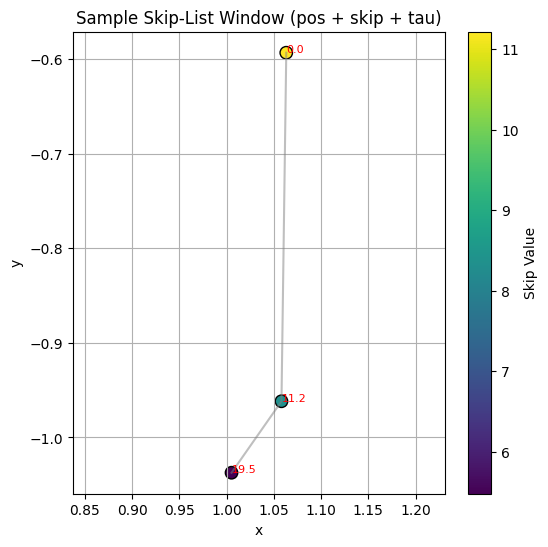

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# --------------------------------------------------------------
# 2. Pick a random sample
# --------------------------------------------------------------
pos, skip_vals, tau_vals = dataset[np.random.randint(len(dataset))]

# Convert tensors to numpy
pos = pos.numpy()
skip_vals = skip_vals.numpy()
tau_vals = tau_vals.numpy()
print("Positions: ", pos)
print("Skip values: ", skip_vals)
print("Tau values: ", tau_vals)
# --------------------------------------------------------------
# 3. Plot positions, color-coded by skip size
# --------------------------------------------------------------

plt.figure(figsize=(6,6))
plt.scatter(
    pos[:,0], pos[:,1],
    c=skip_vals,
    cmap="viridis",
    s=80,
    edgecolor="black"
)

# Draw the path lines
plt.plot(pos[:,0], pos[:,1], color="gray", alpha=0.5)

# Annotate tau
for i, tau in enumerate(tau_vals):
    plt.text(pos[i,0], pos[i,1], f"{tau:.1f}", fontsize=8, color="red")

plt.colorbar(label="Skip Value")
plt.title("Sample Skip-List Window (pos + skip + tau)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()
